In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.interpolate import interp1d
import csv
import json
import re
from io import StringIO
from scipy.signal import find_peaks

In [2]:
%matplotlib widget

# Cardiosomnography data preprocessing

The ECG data needs to be preprocessed, before the ECG data can be given as input for the neural network.

### Read the raw MoveSense ECG data

In [3]:
#Inladen participant 39
#Plot ECG values 
ecg_file = r"C:/Users/esmee/OneDrive\Documenten/Hva jaar 4/Afstudeerstage/data/Esmee/MoveSense_data/MoveSense_participant_39/20240803T214653Z_234230000735_ecg_stream.csv"
df = pd.read_csv(ecg_file) 
raw_ecg_samples = df["sample"].to_numpy()  #voor participant 39
hertz = 125
print("Amount of measured ECG values:", len(raw_ecg_samples))
print("\nFirst and last measured ECG values:\n", raw_ecg_samples)
df




Amount of measured ECG values: 3911168

First and last measured ECG values:
 [-503 -157 -167 ...  -34  -53  -70]


,timestamp,sample
0,74410,-503
1,74418,-157
2,74426,-167
3,74434,-179
4,74442,-118
...,...,...
3911163,31374219,-19
3911164,31374227,-24
3911165,31374235,-34
3911166,31374243,-53


### Visualize ECG values of raw data

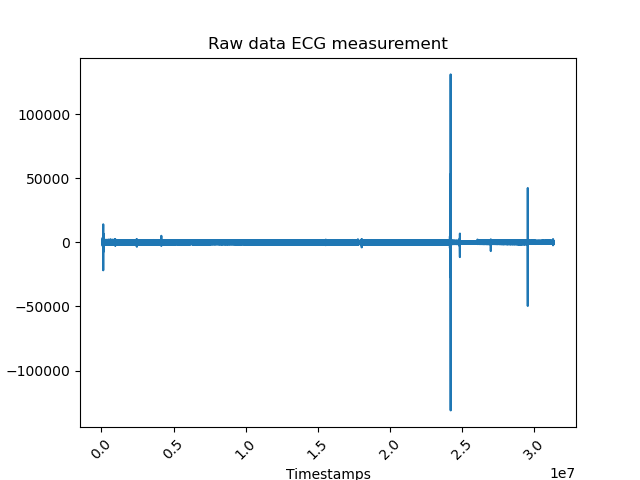

In [4]:
plt.close()
# Plot the ECG values of a whole night
plt.plot(df["timestamp"], df["sample"])
plt.title("Raw data ECG measurement")
plt.xlabel("Timestamps")
plt.xticks(rotation=45)
plt.ylabel("ECG values")
plt.show()

##### What to do with all ECG values above 2500? Delete, clamp, or?

<br><br>

---

### First, get all provided information about the measurement

In [5]:
try:
    # Get the participant number
    participant_number = ecg_file.split("/")[-2]
    participant_number = int(participant_number.split("_")[-1])
    print("Measurement of participant {0}".format(participant_number))
except:
    print("Participant number could not be extracted.")

Measurement of participant 39


In [6]:
# Get the full file name
file_name = ecg_file.split("/")[-1]
# Get the MoveSense ID
movesense_id = file_name.split("_")[1]
print("MoveSense ID: {0}".format(movesense_id))

MoveSense ID: 234230000735


#### Get the date and time of the sleep session

#### Get start timestamp

In [7]:
try:
    # Get the start date out of the file name
    start_date_time = file_name.split("_")[0]
    start_date_time = start_date_time.split("T")
    start_date = start_date_time[0]
    print("Measurement start date:", start_date)

    # Get the start time out of the file name
    start_time = start_date_time[1]
    start_time = start_time.split("Z")[0]
    print("Measurement start time:", start_time)

    # Get the start date and time in a nice format
    start_timestamp = datetime.strptime("{0} {1}".format(start_date, start_time), "%Y%m%d %H%M%S")
    print(start_timestamp)
except:
    print("Start timestamp could not be extracted.\n")
    print("Are you sure you have the correct file name?")
    print("Expected file name should end like this: xxxxxxxxTxxxxxxZ_xxxxxxxxxxxx_ecg_stream.csv")
    print("Your file name looks like this:", ecg_file)

Measurement start date: 20240803
Measurement start time: 214653
2024-08-03 21:46:53


#### Get the measurement duration

In [8]:
# Get timestamps
first_timestamp = df["timestamp"].iloc[0]
last_timestamp = df["timestamp"].iloc[-1]
# Get duration in milliseconds
duration_milliseconds = last_timestamp - first_timestamp
print("Measurement took {0} milliseconds.".format(duration_milliseconds))

Measurement took 31299841 milliseconds.


In [9]:
# Get the measurement duration in seconds
duration_seconds = int(duration_milliseconds / 1000)
# Make a single division to produce both the quotient (minutes) and the remainder (seconds)
minutes, seconds = divmod(duration_seconds, 60)
hours, minutes = divmod(minutes, 60)

In [10]:
print("The measurement duration took {0} seconds.".format(duration_seconds))
print("That amount equals with {} hours, {} minutes, and {} seconds.".format(hours, minutes, seconds))

The measurement duration took 31299 seconds.
That amount equals with 8 hours, 41 minutes, and 39 seconds.


#### Get end timestamp

In [11]:
# Add measurement duration to start timestamp
duration_timestamp = timedelta(seconds=duration_seconds)
end_timestamp = start_timestamp + duration_timestamp
print("Measurement started on {0}".format(start_timestamp))
print("Measurement  ended  on {0}".format(end_timestamp))

Measurement started on 2024-08-03 21:46:53
Measurement  ended  on 2024-08-04 06:28:32


#### Get interval between measurements

In [12]:
# Get average time between each measurement
measurement_interval = duration_seconds / len(df)
hertz = round(1/measurement_interval)
print("Average time interval between each measurement is: ")
print(" - {0:.3f} seconds.".format(measurement_interval))
print(" - {0:.3f} milliseconds.".format(measurement_interval*1000))
print("\nSample rate: {0} Hertz.".format(hertz))

Average time interval between each measurement is: 
 - 0.008 seconds.
 - 8.002 milliseconds.

Sample rate: 125 Hertz.


### Add extra Timestamps for better visualization

In [13]:
# Add extra column with timestamps
def add_timestamps(df, start_timestamp, end_timestamp):
    # Start timestamp and end timestamp
    print("Starting timestamp: ", start_timestamp)
    print("Ending timestamp:", end_timestamp, "\n\n")
    
    # Calculate the total amount of minutes between start- and end time
    total_minutes = (end_timestamp - start_timestamp).total_seconds() / 60
    # Calculate the total amount of measurement per minute
    measurements_per_minute = len(df) / total_minutes
    
    # Create a list of timestamps
    df["Timestamp"] = [start_timestamp + timedelta(minutes=i/measurements_per_minute) for i in range(len(df))]
    return df

In [14]:
# Add timestamps for each measurement
df = add_timestamps(df, start_timestamp, end_timestamp)
df

Starting timestamp:  2024-08-03 21:46:53
Ending timestamp: 2024-08-04 06:28:32 




,timestamp,sample,Timestamp
0,74410,-503,2024-08-03 21:46:53.000000
1,74418,-157,2024-08-03 21:46:53.008002
2,74426,-167,2024-08-03 21:46:53.016005
3,74434,-179,2024-08-03 21:46:53.024007
4,74442,-118,2024-08-03 21:46:53.032010
...,...,...,...
3911163,31374219,-19,2024-08-04 06:28:31.959988
3911164,31374227,-24,2024-08-04 06:28:31.967990
3911165,31374235,-34,2024-08-04 06:28:31.975993
3911166,31374243,-53,2024-08-04 06:28:31.983995


### Visualize raw data

In [15]:
# Visualize ecg data at any time
def plot_data(df, ecg_samples=np.array([]), title="Raw data ECG measurement", y_range=[0,0], x_range=[0,0]):
    plt.close()
    # Plot the ECG values of a whole night
    if ecg_samples.any():
        ecg_samples = pd.Series(ecg_samples)
        plt.plot(df["Timestamp"], ecg_samples)
    else:
        plt.plot(df["Timestamp"], df["sample"])

    # Plot y range
    if y_range != [0,0]:
        plt.ylim(y_range[0], y_range[1])
    # Plot x range
    if x_range != [0,0]:
        plt.xlim(x_range[0], x_range[1])


    plt.title(title)
    plt.xlabel("Timestamps")
    plt.xticks(rotation=30)
    plt.ylabel("ECG values")
    plt.show()

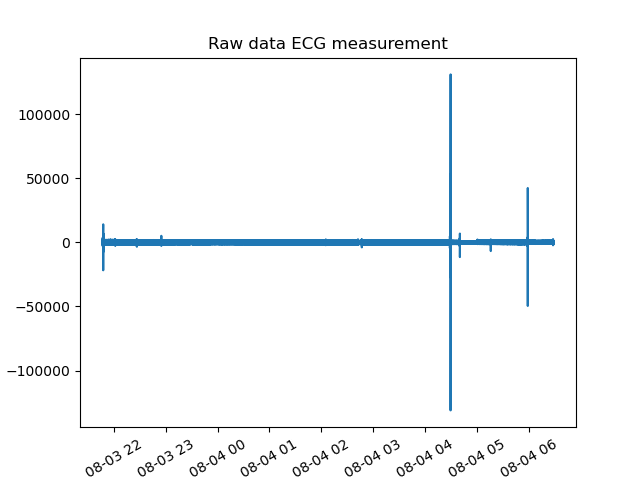

In [16]:
plot_data(df)

<br><br>

---

## Filter noise

### High pass filter

Filter High-pass at 0.5 Hertz to remove baseline wander.

In [17]:
# Signal processing functions for filtering the data
from scipy.signal import butter, filtfilt, iirnotch, resample

In [18]:
# High-pass filter to remove baseline wander
def highpass_filter(data, cutoff=0.5, fs=hertz, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [19]:
# Apply highpass filter to raw ecg samples
filtered_ecg = highpass_filter(raw_ecg_samples)
filtered_ecg

array([  1.50232354, 340.06374681, 322.62819512, ...,  32.1675805 ,
        13.20225448,  -3.76772091])

### Remove line noise

Line noise (50/60 Hertz) and any other constant-frequency noise should be removed with notch filters.

In [20]:
hertz

125

In [21]:
# Notch filter to remove power line noise (e.g., 50/60 Hz)
def notch_filter(data, freq=50, fs=hertz, quality_factor=30):
    nyquist = 0.5 * fs
    freq = freq / nyquist
    b, a = iirnotch(freq, quality_factor)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [22]:
# Apply notch filter for both 50 Hz and (if needed) 60 Hz
filtered_ecg = notch_filter(filtered_ecg, freq=50, fs=hertz)  # Apply 50 Hz notch filter
filtered_ecg

array([  1.52229169, 337.67488976, 325.66074789, ...,  32.29548452,
        12.92162532,  -3.44108095])

In [23]:
filtered_ecg = notch_filter(filtered_ecg, freq=60, fs=hertz)  # Apply 60 Hz notch filter (if applicable)
filtered_ecg

array([  1.54322076, 336.99560471, 326.09882881, ...,  32.21200155,
        12.91029627,  -3.32380545])

In [24]:
df["Timestamp"][0]

Timestamp('2024-08-03 21:46:53')

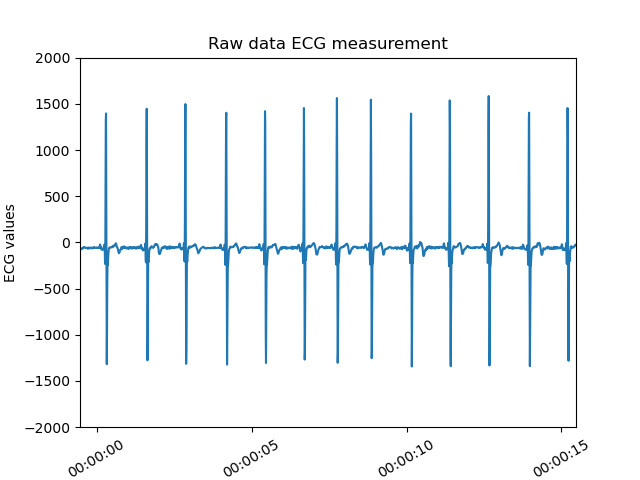

In [25]:
x_range = [df["Timestamp"][998000], df["Timestamp"][1000000]]
y_range = [-2000, 2000]
plot_data(df, y_range=y_range, x_range=x_range)

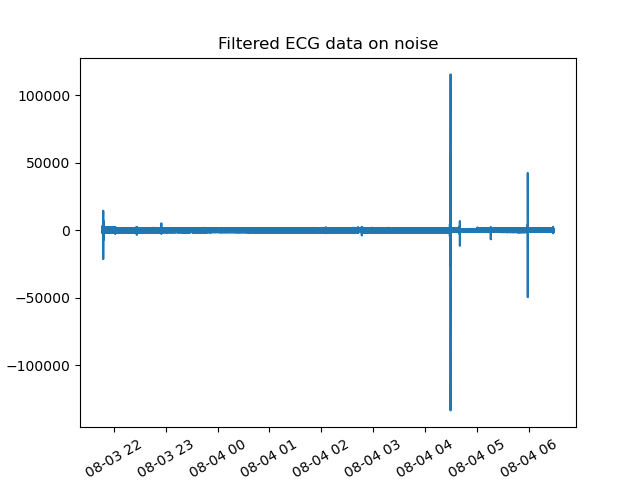

In [26]:
title = "Filtered ECG data on noise"
plot_data(df, filtered_ecg, title)

<br><br>

---

## Sample data at 256 Hertz

Sample the data from the originally measured 125 Hertz to the new 256 Hertz.

This resampling takes place, because the neural network is trained on ECG datasets of 256 Hertz.

#### Sample ECG data

In [27]:
new_hertz = 256 # New amount of Hertz
# Resample the ECG data from 125 Hz to 256 Hz
resampled_ecg = resample(filtered_ecg, int(len(filtered_ecg) * (new_hertz / hertz)))
resampled_ecg

array([  1.54322076, 163.52513097, 331.28154738, ...,  25.54110805,
        -5.71363116, -46.27436271])

#### Resample time axis

In [28]:
original_timestamps = df["timestamp"].to_numpy() # Original timestamps numpy array
original_timestamps

array([   74410,    74418,    74426, ..., 31374235, 31374243, 31374251],
      dtype=int64)

In [29]:
# Lineaire interpolation for timestamps
time_original = np.arange(len(original_timestamps)) / hertz  # Original timesteps in seconds
time_resampled = np.linspace(0, time_original[-1], len(resampled_ecg))  # New timesteps in seconds

print("Original timesteps: ", time_original[:5], "...", time_original[-5:])
print("Resampled timesteps:", time_resampled[:5], "...", time_resampled[-5:])

Original timesteps:  [0.    0.008 0.016 0.024 0.032] ... [31289.304 31289.312 31289.32  31289.328 31289.336]
Resampled timesteps: [0.         0.00390625 0.0078125  0.01171875 0.015625  ] ... [31289.320375   31289.32428125 31289.3281875  31289.33209375
 31289.336     ]


In [30]:
# Interpolate original timestamps to new time-axis
resampled_timestamps = np.interp(time_resampled, time_original, original_timestamps)

print("Original timestamps: ", original_timestamps[:5], "...", original_timestamps[-5:])
print("Resampled timestamps:", resampled_timestamps[:5], "...", resampled_timestamps[-5:])

Original timestamps:  [74410 74418 74426 74434 74442] ... [31374219 31374227 31374235 31374243 31374251]
Resampled timestamps: [74410.         74413.90624952 74417.81249904 74421.71874856
 74425.62499808] ... [31374235.37500192 31374239.28125143 31374243.18750096 31374247.09375048
 31374251.        ]


In [31]:
resampled_df = pd.DataFrame({
    'timestamp': resampled_timestamps,
    'sample': resampled_ecg
})

In [32]:
# Add timestamps for each measurement
resampled_df = add_timestamps(resampled_df, start_timestamp, end_timestamp)
resampled_df

Starting timestamp:  2024-08-03 21:46:53
Ending timestamp: 2024-08-04 06:28:32 




,timestamp,sample,Timestamp
0,7.441000e+04,1.543221,2024-08-03 21:46:53.000000
1,7.441391e+04,163.525131,2024-08-03 21:46:53.003907
2,7.441781e+04,331.281547,2024-08-03 21:46:53.007815
3,7.442172e+04,384.393096,2024-08-03 21:46:53.011722
4,7.442562e+04,332.674793,2024-08-03 21:46:53.015630
...,...,...,...
8010067,3.137424e+07,6.746462,2024-08-04 06:28:31.980463
8010068,3.137424e+07,14.673644,2024-08-04 06:28:31.984370
8010069,3.137424e+07,25.541108,2024-08-04 06:28:31.988278
8010070,3.137425e+07,-5.713631,2024-08-04 06:28:31.992185


In [33]:
df.shape

(3911168, 3)

In [34]:
print(resampled_df.head())

      timestamp      sample                  Timestamp
0  74410.000000    1.543221 2024-08-03 21:46:53.000000
1  74413.906250  163.525131 2024-08-03 21:46:53.003907
2  74417.812499  331.281547 2024-08-03 21:46:53.007815
3  74421.718749  384.393096 2024-08-03 21:46:53.011722
4  74425.624998  332.674793 2024-08-03 21:46:53.015630


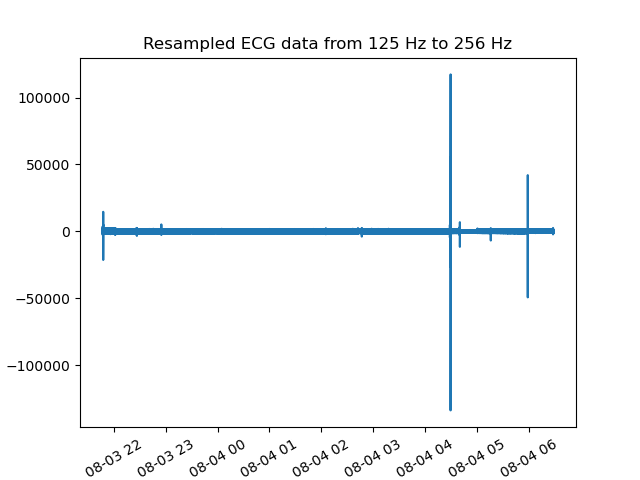

In [35]:
title = f"Resampled ECG data from {hertz} Hz to {new_hertz} Hz"
plot_data(resampled_df, title=title)

<br><br>

---

## Scale data - 1 / 2

### Subtract median data

The median of all data should be subtracted. The median of all ECG data should be equal to 0.

In [36]:
# Calculate the median of the resampled ECG data
median_ecg = np.median(resampled_ecg)
median_ecg

2.162302892177118

In [37]:
# Subtract the median to center the data around 0
centered_ecg = resampled_ecg - median_ecg

In [38]:
np.abs(np.median(centered_ecg))

0.0

In [39]:
resampled_df["sample"] = centered_ecg
resampled_df

,timestamp,sample,Timestamp
0,7.441000e+04,-0.619082,2024-08-03 21:46:53.000000
1,7.441391e+04,161.362828,2024-08-03 21:46:53.003907
2,7.441781e+04,329.119244,2024-08-03 21:46:53.007815
3,7.442172e+04,382.230793,2024-08-03 21:46:53.011722
4,7.442562e+04,330.512490,2024-08-03 21:46:53.015630
...,...,...,...
8010067,3.137424e+07,4.584159,2024-08-04 06:28:31.980463
8010068,3.137424e+07,12.511342,2024-08-04 06:28:31.984370
8010069,3.137424e+07,23.378805,2024-08-04 06:28:31.988278
8010070,3.137425e+07,-7.875934,2024-08-04 06:28:31.992185


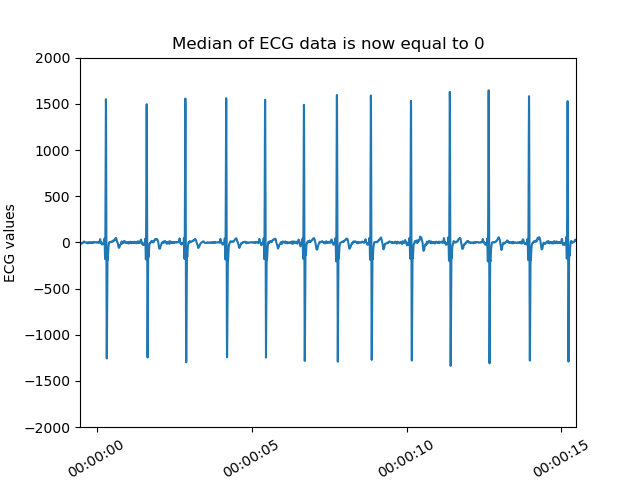

In [40]:
title = "Median of ECG data is now equal to 0"
plot_data(resampled_df, centered_ecg, title, y_range=y_range, x_range=x_range)

---

## Spikes & HeartRate

### Calculate threshold of heartbeat spikes

In [41]:
spike_threshold = np.std(resampled_df["sample"])
spike_threshold

747.9287568421274

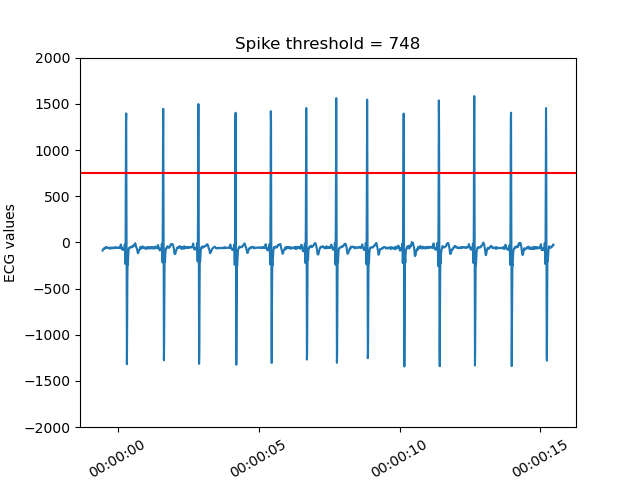

In [42]:
plt.close()
# Plot ECG values with threshold line
plt.plot(df["Timestamp"][998000:1000000], df["sample"][998000:1000000])
plt.ylim([-2000, 2000])
# Plot threshold line
plt.axhline(spike_threshold, color="r")
plt.title("Spike threshold = {:.0f}".format(spike_threshold))
plt.xlabel("Timestamps")
plt.xticks(rotation=30)
plt.ylabel("ECG values")
plt.show()

In [43]:
hertz

125

### Detect all potential spikes

In [44]:
# Detect all potential spikes
fs=hertz
peaks = find_peaks(df["sample"], height=spike_threshold, distance=fs*0.6)
peaks

(array([    127,     256,     383, ..., 3910867, 3910992, 3911117],
       dtype=int64),
 {'peak_heights': array([1572., 1697., 1689., ..., 1111., 1073., 1108.])})

c:\Users\esmee\anaconda3\Lib\site-packages\ipympl\backend_nbagg.py:335: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


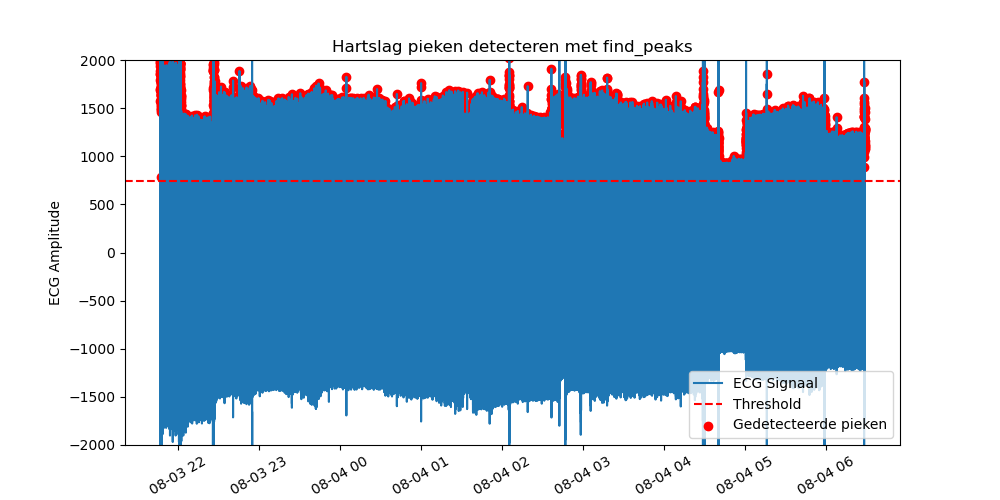

Aantal gedetecteerde pieken: 26533


In [45]:
# Gebruik find_peaks om pieken te detecteren
fs=hertz
peaks, properties = find_peaks(df["sample"], height=spike_threshold, distance=fs*0.6)

# Plot ECG met gedetecteerde pieken
plt.figure(figsize=(10, 5))
plt.plot(df["Timestamp"], df["sample"], label="ECG Signaal")
plt.ylim([-2000, 2000])
plt.axhline(spike_threshold, color="r", linestyle="--", label="Threshold")

# Plot pieken
plt.scatter(df["Timestamp"].iloc[peaks], df["sample"].iloc[peaks], color='red', marker='o', label="Gedetecteerde pieken")

# Labels en titel
plt.title("Hartslag pieken detecteren met find_peaks")
plt.xlabel("Tijd (s)")
plt.ylabel("ECG Amplitude")
plt.xticks(rotation=30)
plt.legend()
plt.show()

# Toon aantal pieken
print(f"Aantal gedetecteerde pieken: {len(peaks)}")

In [46]:
# Haal de tijdstempels van de gedetecteerde pieken
peak_timestamps = df["Timestamp"].iloc[peaks]

# Bereken de tijdsverschillen tussen de pieken (RR-intervals) in seconden
time_differences = peak_timestamps.diff().dt.total_seconds()

# Verwijder de eerste NaN waarde (er is geen verschil voor de eerste piek)
#time_differences = time_differences[1:]

# Bekijk de eerste paar tijdsverschillen
print(time_differences.head(20))

127          NaN
256     1.032318
383     1.016314
504     0.968298
618     0.912282
732     0.912281
846     0.912282
960     0.912281
1071    0.888274
1174    0.824254
1276    0.816252
1376    0.800247
1472    0.768237
1567    0.760235
1663    0.768237
1769    0.848261
1879    0.880272
1996    0.936289
2111    0.920284
2230    0.952293
Name: Timestamp, dtype: float64


In [47]:
# Bereken de hartslag per piek (BPM)
bpm_values = 60 / time_differences

# Toon de BPM-waarden voor de eerste paar pieken
print(bpm_values.head(20))

127           NaN
256     58.121625
383     59.036872
504     61.964395
618     65.769137
732     65.769209
846     65.769137
960     65.769209
1071    67.546725
1174    72.793095
1276    73.506711
1376    74.976851
1472    78.100899
1567    78.922965
1663    78.100899
1769    70.732947
1879    68.160750
1996    64.082778
2111    65.197265
2230    63.005819
Name: Timestamp, dtype: float64


In [48]:
# Maak een nieuw DataFrame voor de gedetecteerde pieken
spike_value_df = df.iloc[peaks]  # Gebruik de indices van de pieken om de relevante rijen te selecteren

# Voeg de tijdsverschillen toe aan dit nieuwe DataFrame (al eerder berekend)
spike_value_df["time_differences"] = time_differences.values
# Bereken de hartslag voor elke piek (in bpm)
spike_value_df["heartrate"] = 60 / spike_value_df["time_differences"]

# Bekijk het nieuwe DataFrame
print(spike_value_df.head(20))

      timestamp  sample                  Timestamp  time_differences  \
127       75426    1572 2024-08-03 21:46:54.016314               NaN   
256       76458    1697 2024-08-03 21:46:55.048632          1.032318   
383       77474    1689 2024-08-03 21:46:56.064946          1.016314   
504       78442    1976 2024-08-03 21:46:57.033244          0.968298   
618       79354    3567 2024-08-03 21:46:57.945526          0.912282   
732       80266    3283 2024-08-03 21:46:58.857807          0.912281   
846       81178    1888 2024-08-03 21:46:59.770089          0.912282   
960       82090    1937 2024-08-03 21:47:00.682370          0.912281   
1071      82978    1972 2024-08-03 21:47:01.570644          0.888274   
1174      83802    1856 2024-08-03 21:47:02.394898          0.824254   
1276      84618    1859 2024-08-03 21:47:03.211150          0.816252   
1376      85418    1997 2024-08-03 21:47:04.011397          0.800247   
1472      86186    1792 2024-08-03 21:47:04.779634          0.76

C:\Users\esmee\AppData\Local\Temp\ipykernel_13392\1584834455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df["time_differences"] = time_differences.values
C:\Users\esmee\AppData\Local\Temp\ipykernel_13392\1584834455.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df["heartrate"] = 60 / spike_value_df["time_differences"]


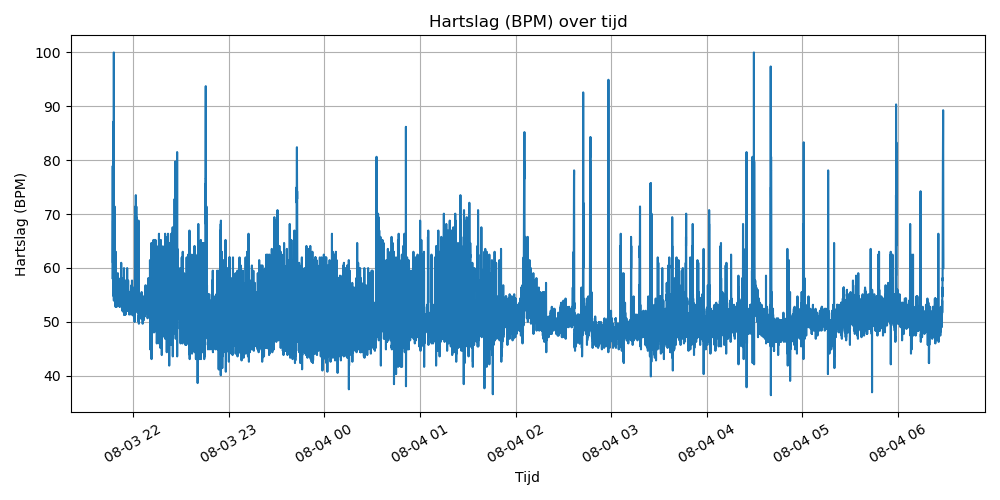

In [49]:
# Plot van de hartslag over tijd
plt.figure(figsize=(10, 5))
plt.plot(spike_value_df["Timestamp"], spike_value_df["heartrate"])
plt.title("Hartslag (BPM) over tijd")
plt.xlabel("Tijd")
plt.ylabel("Hartslag (BPM)")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
spike_value_df["heartrate"].max()

99.96917617068071

In [51]:
len(spike_value_df)

26533

In [ ]:
# # Detect all points above the threshold
# above_threshold = resampled_df.copy()
# above_threshold = above_threshold[above_threshold["sample"] > spike_threshold]
# above_threshold_samples = above_threshold.shape[0]
# print("Samples in cleaned dataset:", resampled_df.shape[0])
# print("Samples above threshold:   ", above_threshold_samples)
# above_threshold[:10]

Samples in cleaned dataset: 8010072
Samples above threshold:    136914


,timestamp,sample,Timestamp
258,75417.812376,1046.726272,2024-08-03 21:46:54.008124
259,75421.718626,1415.077738,2024-08-03 21:46:54.012031
260,75425.624875,1565.210791,2024-08-03 21:46:54.015938
261,75429.531125,1417.149528,2024-08-03 21:46:54.019846
262,75433.437374,972.852910,2024-08-03 21:46:54.023753
522,76449.062250,1226.022214,2024-08-03 21:46:55.039692
523,76452.968499,1620.269518,2024-08-03 21:46:55.043599
524,76456.874749,1780.120253,2024-08-03 21:46:55.047507
525,76460.780998,1622.029930,2024-08-03 21:46:55.051414
526,76464.687248,1148.686979,2024-08-03 21:46:55.055322


In [ ]:
# # Variable how many seconds one spike lasts at max (200 milliseconds)
# spike_duration = 0.2
# # Calculate how many samples 1 spike lasts at max
# spike_duration_samples = int(spike_duration * hertz)
# print("1 spike is always happening in less than {0} samples.".format(spike_duration_samples))

1 spike is always happening in less than 25 samples.


### Detect only the real spikes

In [ ]:
# # Calculate time differences between sequenced measurements
# above_threshold["time_differences"] = above_threshold['Timestamp'].diff().dt.total_seconds() * 1000  # Difference in milliseconds
# above_threshold["time_differences"][:3]

258      NaN
259    3.907
260    3.907
Name: time_differences, dtype: float64

In [ ]:
# # Fill first value of time difference with 1000 instead of NaN, because there is no previous value (This detects the first spike)
# first_index = above_threshold.index[0]
# above_threshold.loc[first_index, "time_differences"] = 1000
# above_threshold[:5]

,timestamp,sample,Timestamp,time_differences
258,75417.812376,1046.726272,2024-08-03 21:46:54.008124,1000.000
259,75421.718626,1415.077738,2024-08-03 21:46:54.012031,3.907
260,75425.624875,1565.210791,2024-08-03 21:46:54.015938,3.907
261,75429.531125,1417.149528,2024-08-03 21:46:54.019846,3.908
262,75433.437374,972.852910,2024-08-03 21:46:54.023753,3.907


In [ ]:
# # Group potential spikes in heartbeats
# minimum_spike_time_difference = 200
# above_threshold['heartbeat_group'] = (above_threshold['time_differences'] > minimum_spike_time_difference).cumsum()
# above_threshold[:20]

,timestamp,sample,Timestamp,time_differences,heartbeat_group
258,75417.812376,1046.726272,2024-08-03 21:46:54.008124,1000.000,1
259,75421.718626,1415.077738,2024-08-03 21:46:54.012031,3.907,1
260,75425.624875,1565.210791,2024-08-03 21:46:54.015938,3.907,1
261,75429.531125,1417.149528,2024-08-03 21:46:54.019846,3.908,1
262,75433.437374,972.852910,2024-08-03 21:46:54.023753,3.907,1
522,76449.062250,1226.022214,2024-08-03 21:46:55.039692,1015.939,2
523,76452.968499,1620.269518,2024-08-03 21:46:55.043599,3.907,2
524,76456.874749,1780.120253,2024-08-03 21:46:55.047507,3.908,2
525,76460.780998,1622.029930,2024-08-03 21:46:55.051414,3.907,2
526,76464.687248,1148.686979,2024-08-03 21:46:55.055322,3.908,2


In [ ]:
# # Select only the rows with the highest sample value in each group (The spike)
# # Add spike values to spike values dataset
# spike_value_df = above_threshold.loc[above_threshold.groupby('heartbeat_group')['sample'].idxmax()]
# # Keep al relevant columns
# spike_value_df = spike_value_df[["timestamp", "sample", "Timestamp"]]
# spike_value_df

,timestamp,sample,Timestamp
260,7.542562e+04,1565.210791,2024-08-03 21:46:54.015938
524,7.645687e+04,1780.120253,2024-08-03 21:46:55.047507
784,7.747250e+04,1751.028439,2024-08-03 21:46:56.063445
1032,7.844125e+04,1969.231700,2024-08-03 21:46:57.032494
1207,7.912484e+04,940.370146,2024-08-03 21:46:57.716299
...,...,...,...
8008968,3.136994e+07,1357.196142,2024-08-04 06:28:27.686169
8009209,3.137088e+07,1280.466879,2024-08-04 06:28:28.627866
8009456,3.137185e+07,1199.069729,2024-08-04 06:28:29.593007
8009712,3.137285e+07,1169.911300,2024-08-04 06:28:30.593316


### Plot spikes

c:\Users\esmee\anaconda3\Lib\site-packages\ipympl\backend_nbagg.py:335: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


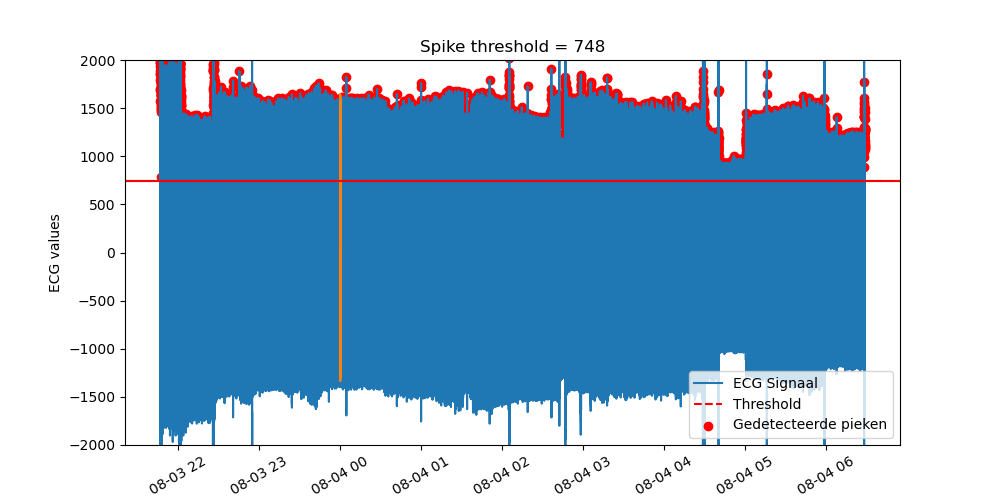

In [52]:
resampled_x_range = [2044000, 2048000]
spikes_x_range = [6851, 6864]

plt.close()
# Plot ECG values with threshold line
plt.plot(resampled_df["Timestamp"][resampled_x_range[0]:resampled_x_range[1]], resampled_df["sample"][resampled_x_range[0]:resampled_x_range[1]])
#plt.plot(df["Timestamp"][998000:1000000], df["sample"][998000:1000000])
plt.ylim([-2000, 2000])
# Plot threshold line
plt.axhline(spike_threshold, color="r")
# Plot all spikes
plt.scatter(spike_value_df["Timestamp"][spikes_x_range[0]:spikes_x_range[1]], spike_value_df["sample"][spikes_x_range[0]:spikes_x_range[1]], c="r", s=10)
# Customize lay-out
plt.title("Spike threshold = {:.0f}".format(spike_threshold))
plt.xlabel("Timestamps")
plt.xticks(rotation=30)
plt.ylabel("ECG values")
plt.show()

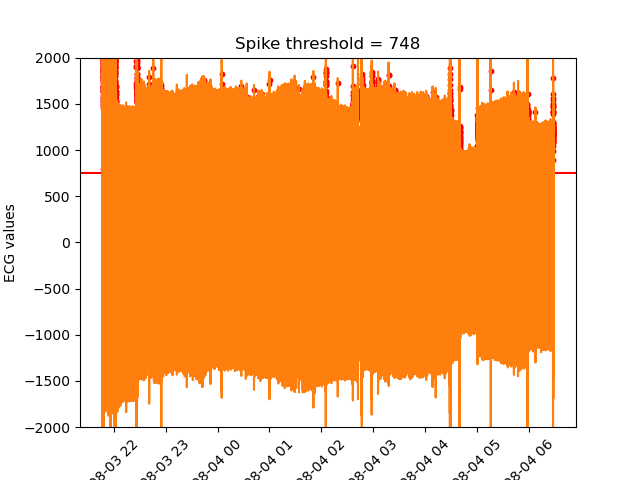

In [53]:
plt.close()
# Plot ECG values with threshold line
plt.plot(resampled_df["Timestamp"], resampled_df["sample"])
# Plot threshold line
# plt.axhline(spike_threshold, color="r")
# Plot all spikes
plt.scatter(spike_value_df["Timestamp"], spike_value_df["sample"], c="r", s=10)
# Customize lay-out
# plt.title("ECG measurement \nfrom {0} \n  till {1}\nSpike threshold = {2:.0f}".format(start_timestamp, end_timestamp, spike_threshold))
plt.xlabel("Timestamps")
plt.xticks(rotation=45)
plt.ylabel("ECG values")
plt.show()

### Calculate InterBeat Interval

In [ ]:
# # Calculate time differences between all spikes (again, but only between real spikes now)
# spike_value_df["time_differences"] = spike_value_df['Timestamp'].diff().dt.total_seconds() * 1000  # Difference in milliseconds
# spike_value_df["time_differences"][:10]

C:\Users\esmee\AppData\Local\Temp\ipykernel_9652\2162462268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df["time_differences"] = spike_value_df['Timestamp'].diff().dt.total_seconds() * 1000  # Difference in milliseconds


127          NaN
256     1032.318
383     1016.314
504      968.298
618      912.282
732      912.281
846      912.282
960      912.281
1071     888.274
1174     824.254
Name: time_differences, dtype: float64

In [ ]:
# # Fill first value of time difference with 1000 instead of NaN, because there is no previous value (This detects the first spike)
# first_index = spike_value_df.index[0]
# spike_value_df.loc[first_index, "time_differences"] = 1000
# spike_value_df[:5]

,timestamp,sample,Timestamp,time_differences,heartrate
127,75426,1572,2024-08-03 21:46:54.016314,1000.000,NaN
256,76458,1697,2024-08-03 21:46:55.048632,1032.318,58.121625
383,77474,1689,2024-08-03 21:46:56.064946,1016.314,59.036872
504,78442,1976,2024-08-03 21:46:57.033244,968.298,61.964395
618,79354,3567,2024-08-03 21:46:57.945526,912.282,65.769137


### Calculate heart rate

In [ ]:
# spike_value_df["heartrate"] = 60 / spike_value_df["time_differences"] * 1000
# spike_value_df

C:\Users\esmee\AppData\Local\Temp\ipykernel_9652\3364203393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df["heartrate"] = 60 / spike_value_df["time_differences"] * 1000


,timestamp,sample,Timestamp,time_differences,heartrate
127,75426,1572,2024-08-03 21:46:54.016314,1000.000,60.000000
256,76458,1697,2024-08-03 21:46:55.048632,1032.318,58.121625
383,77474,1689,2024-08-03 21:46:56.064946,1016.314,59.036872
504,78442,1976,2024-08-03 21:46:57.033244,968.298,61.964395
618,79354,3567,2024-08-03 21:46:57.945526,912.282,65.769137
...,...,...,...,...,...
3910629,31369947,1288,2024-08-04 06:28:27.686669,920.284,65.197265
3910746,31370883,1127,2024-08-04 06:28:28.622958,936.289,64.082778
3910867,31371851,1111,2024-08-04 06:28:29.591257,968.299,61.964331
3910992,31372851,1073,2024-08-04 06:28:30.591565,1000.308,59.981526


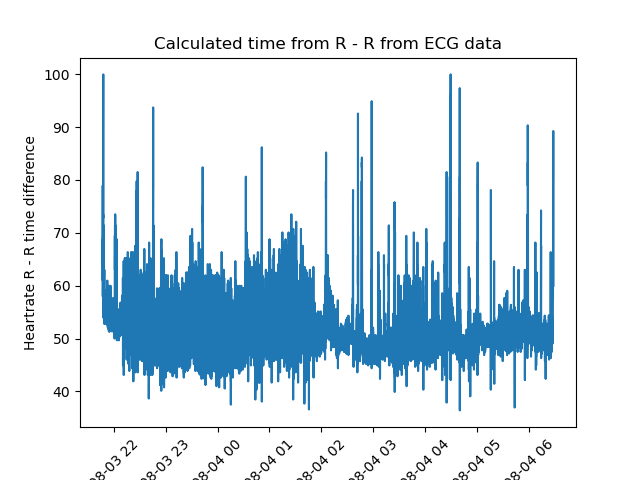

In [54]:
plt.close()
# Plot the ECG values of a whole night
plt.plot(spike_value_df["Timestamp"], spike_value_df["heartrate"])
plt.title("Calculated time from R - R from ECG data")
plt.xlabel("Timestamps")
plt.xticks(rotation=45)
plt.ylabel("Heartrate R - R time difference")
plt.show()

---

## Scale data - 2 / 2

### Scale ECG to range [-0.5, 0.5]

First measure the minimum and maximum values of every heartbeat. (So not of all ECG data, but just of the heartbeats).<br>
The data should be scaled, such that the 90th percentile (or greater) of the minimum and maximum heartbeat values lies within the range [-0.5, 0.5].

Movement artifacts and other noise may exceed the amplitude of most heartbeats. <br>
Noisy data values may lie within the range of [-1.0, -0.5] and [0.5, 1.0]. 

In [55]:
# Only get all heartbeat values (spikes)
spike_values = spike_value_df["sample"]
spike_values

127        1572
256        1697
383        1689
504        1976
618        3567
           ... 
3910629    1288
3910746    1127
3910867    1111
3910992    1073
3911117    1108
Name: sample, Length: 26533, dtype: int64

In [56]:
# Calculate the 90th percentile of min/max heartbeat values
min_value = np.percentile(spike_values, 10)
max_value = np.percentile(spike_values, 90)
print("The 90th percentile of the minimum heartbeat values:", min_value)
print("The 90th percentile of the maximum heartbeat values:", max_value)

The 90th percentile of the minimum heartbeat values: 1187.0
The 90th percentile of the maximum heartbeat values: 1559.0


In [57]:
# Scale factor based on the biggest, most absolut value
scale_factor = 0.5 / max(abs(min_value), abs(max_value))
print("Scale factor:", scale_factor)

Scale factor: 0.00032071840923669016


In [58]:
# Scale using the 90th percentile of min/max heartbeat values, without an adjustment
scaled_ecg = centered_ecg * scale_factor
resampled_df["sample"] = scaled_ecg
resampled_df

,timestamp,sample,Timestamp
0,7.441000e+04,-0.000199,2024-08-03 21:46:53.000000
1,7.441391e+04,0.051752,2024-08-03 21:46:53.003907
2,7.441781e+04,0.105555,2024-08-03 21:46:53.007815
3,7.442172e+04,0.122588,2024-08-03 21:46:53.011722
4,7.442562e+04,0.106001,2024-08-03 21:46:53.015630
...,...,...,...
8010067,3.137424e+07,0.001470,2024-08-04 06:28:31.980463
8010068,3.137424e+07,0.004013,2024-08-04 06:28:31.984370
8010069,3.137424e+07,0.007498,2024-08-04 06:28:31.988278
8010070,3.137425e+07,-0.002526,2024-08-04 06:28:31.992185


In [59]:
print("Is the median still equal to 0?")
print("Median:", np.abs(np.median(scaled_ecg)))

Is the median still equal to 0?
Median: 0.0


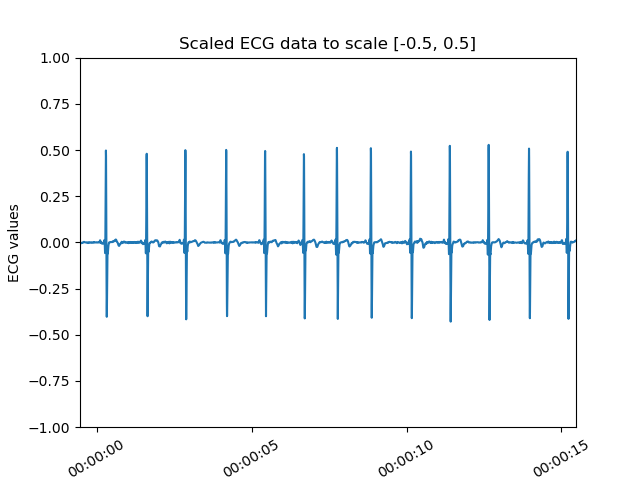

In [60]:
title = "Scaled ECG data to scale [-0.5, 0.5]"
plot_data(resampled_df, scaled_ecg, title, x_range=x_range, y_range=[-1, 1])

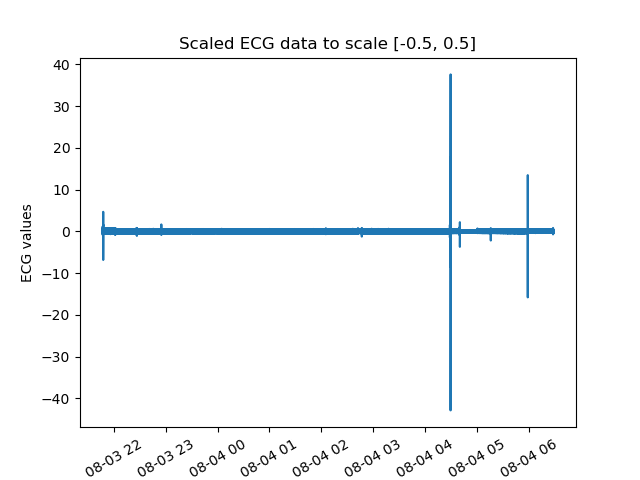

In [61]:
plot_data(resampled_df, scaled_ecg, title)

### Clamp outliers

All noisy datapoints and even the "tall" heartbeats should lie between the range of [-1.0, 1.0].<br>
Outliers should all be clamped to [-1.0, 1.0].

In [62]:
# Clamp values to [-1.0, 1.0] to handle noise and tall heartbeats
clamped_ecg = np.clip(scaled_ecg, -1.0, 1.0)
clamped_ecg

array([-0.00019855,  0.05175203,  0.1055546 , ...,  0.00749801,
       -0.00252596, -0.01553453])

In [63]:
print("Is the median still equal to 0?")
print("Median:", np.abs(np.median(clamped_ecg)))

Is the median still equal to 0?
Median: 0.0


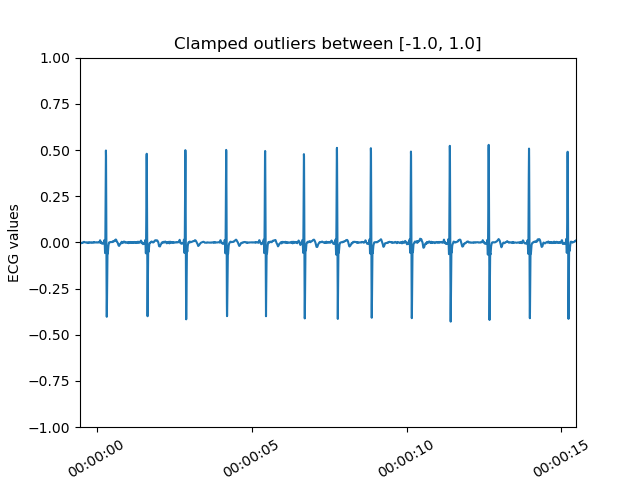

In [64]:
title = "Clamped outliers between [-1.0, 1.0]"
plot_data(resampled_df, clamped_ecg, title, x_range=x_range, y_range=[-1, 1])

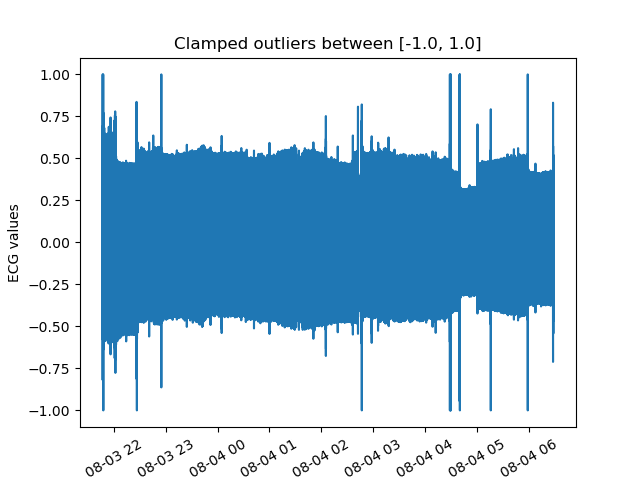

In [65]:
plot_data(resampled_df, clamped_ecg, title)

<br><br>

---

## Reshape into 30-second epochs

In the last preprocessing step, the ECG values should be divided into 30-second epochs. <br>
These 30-second epochs should be added to a new dataset as individual rows. <br>
The shape of the dataset will be [epoch_count * 7680]. The 7680 columns originate from 30 seconds * 256 Hertz. 

In [66]:
# Calculate the new 2D array shape
epoch_length = 30 * new_hertz # 30 seconds * 256 Hertz = 7680 datapoints per epoch
epoch_count = len(clamped_ecg) // epoch_length
print("Dataset shape: ({}, {})".format(epoch_count, epoch_length))

Dataset shape: (1042, 7680)


In [67]:
# Trim ECG data down to the next nearest 30 second epoch length
trimmed_ecg = clamped_ecg[:epoch_count * epoch_length] # ECG length is now a multiple of 30 seconds
print("Amount of measurements taken into account:", len(trimmed_ecg))

Amount of measurements taken into account: 8002560


In [68]:
# Reshape the ECG data into 2D array
ecgs = clamped_ecg[:epoch_count * epoch_length].reshape((epoch_count, epoch_length))
pd.DataFrame(ecgs)

,0,1,2,3,4,5,6,7,8,9,...,7670,7671,7672,7673,7674,7675,7676,7677,7678,7679
0,-0.000199,0.051752,0.105555,0.122588,0.106001,0.090068,0.093949,0.106544,0.113493,0.116998,...,0.002658,0.001034,0.000015,-0.000269,0.000197,0.001442,0.003467,0.006038,0.008590,0.010427
1,0.011079,0.010519,0.009130,0.007432,0.005721,0.003945,0.002054,0.000499,0.000145,0.001569,...,-0.002618,-0.005634,-0.007717,-0.009028,-0.009179,-0.008071,-0.006569,-0.006000,-0.006994,-0.009021
2,-0.011085,-0.012631,-0.013654,-0.014223,-0.014210,-0.013447,-0.011993,-0.010344,-0.009491,-0.010398,...,0.008552,0.007361,0.004746,0.000820,-0.004156,-0.009950,-0.015990,-0.021236,-0.024733,-0.026216
3,-0.026108,-0.025120,-0.023972,-0.023144,-0.022520,-0.021435,-0.019405,-0.016756,-0.014281,-0.012426,...,0.006861,0.005819,0.003820,0.002501,0.002613,0.003724,0.004864,0.005366,0.005258,0.004991
4,0.004851,0.004642,0.003927,0.002444,0.000203,-0.002653,-0.005723,-0.007981,-0.007915,-0.004450,...,0.000512,0.000355,-0.000478,-0.001447,-0.001829,-0.001408,-0.000542,0.000339,0.001084,0.001724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,-0.002630,-0.001554,-0.000211,0.001150,0.002167,0.002501,0.001996,0.000606,-0.001595,-0.004095,...,0.004228,0.004973,0.005940,0.006665,0.007105,0.007569,0.008407,0.009748,0.011438,0.013237
1038,0.015080,0.017028,0.018941,0.020462,0.021421,0.022052,0.022630,0.023130,0.023433,0.023639,...,0.008405,0.008736,0.009307,0.010135,0.010849,0.011348,0.012092,0.013425,0.015048,0.016536
1039,0.017933,0.019419,0.020793,0.021782,0.022487,0.023005,0.022967,0.022106,0.020991,0.020468,...,0.006841,0.007661,0.008723,0.010102,0.011857,0.013551,0.014635,0.015181,0.015728,0.016530
1040,0.017450,0.018499,0.019862,0.021366,0.022461,0.022817,0.022494,0.021499,0.019794,0.017849,...,0.000324,0.000233,-0.000275,-0.000707,-0.000830,-0.001007,-0.001434,-0.001693,-0.001415,-0.000870


<br><br>

---

## Convert array to HDF5 file

Convert the 2D Numpy array with all the preprocessed ECG values of a single night of sleep to a HDF5 file format, which is required by the feed-forward neural network to predict a sleep score.

Structure of the HDF5 dataset file:
- `ecgs`:
  - 2D array of floats (size: epoch_count x 7680)
  - Where 7680 = 30 x 256Hz.
  - Network was trained on raw ECG data that had been filtered and scaled appropriately. See **Data preprocessing** above.
- `demographics`:
  - 2D array of floats (size: 2 x 1):
    - 1st: sex (0=female, 1=male)
    - 2nd: age (age_in_years/100)
- `midnight_offset`:
  - A float that represents the clock time offset to the nearest midnight of when the recording began:
    - 0 = midnight
    - -1 = 24hr before midnight and 1 = 24hr after midnight
    - For example, 9pm = -0.125 and 3am = 0.125.
- `stages` (only required for training):
  - 2D array of floats (size: epoch_count x 1):
    - Stage mapping: 0=Wake, 1=N1/S1, 2=N2/S2, 3=N3/S3/S4, 4=REM.
      - It is not uncommon to find REM mapped to 5. However, the network was trained with data with both AASM and R&K scorings, so a unified "deep sleep" score was mapped to 3. And because it's inconvenient to have a gap, REM was remapped to 4.
    - All "unscored" epochs should be mapped to 0 (also see weight below).
- `weights` (only required for training):
  - 2D array of floats (size: epoch_count x 1):
    - 0 (no weight) to 1 (full weight)
    - All "unscored" epochs should be given a weight of 0.

In [69]:
# Check if 'ecgs' is in correct format
print("ECG size should be: \t(epoch_count x 7680)")
print(f"ECG size is: \t\t{ecgs.shape}")

print("\nECG type should be a: \t2D numpy array of floats")
print(f"ECG types are: \t\t{type(ecgs)} \n\t\t\t{type(ecgs[1][1])}")

ECG size should be: 	(epoch_count x 7680)
ECG size is: 		(1042, 7680)

ECG type should be a: 	2D numpy array of floats
ECG types are: 		<class 'numpy.ndarray'> 
			<class 'numpy.float64'>


#### Demographics

In [70]:
# Calculate demographics
def get_demographics(gender, age):
    # Convert gender in binary number
    if gender.lower() == "Male" or "M" or "Man":
        sex = 1
    elif gender.lower() == "Female" or "F" or "Woman":
        sex = 0
    else:
        return "Gender is not entered correctly. Please insert Male or Female"
    
    # Convert age in Floating number
    age = age/100
    
    # Return calculated demographics
    return np.array([sex, age])

In [71]:
# Get demographics
gender = "Male"
age = 40
demographics = get_demographics(gender, age)

In [72]:
# Check if 'demographics' is in correct format
print("Demographics size should be: \t(2 x 1)")
print(f"Demographics size is: \t\t{demographics.shape}")

print("\nDemographics should be contain a 2D array of floats representing:")
print(" - Sex: Binary digit (0=female or 1=male)")
print(" - Age: Floating number (age/100)")

print("\nDemographics variable contains:")
print(" - Sex:", demographics[0])
print(" - Age:", demographics[1])

Demographics size should be: 	(2 x 1)
Demographics size is: 		(2,)

Demographics should be contain a 2D array of floats representing:
 - Sex: Binary digit (0=female or 1=male)
 - Age: Floating number (age/100)

Demographics variable contains:
 - Sex: 1.0
 - Age: 0.4


In [73]:
from tabulate import tabulate

In [74]:
table = [[gender, age]]
headers = ["Gender", "Age"]
print(tabulate(table, headers, tablefmt="pretty"))

+--------+-----+
| Gender | Age |
+--------+-----+
|  Male  | 40  |
+--------+-----+


#### Midnight offset

In [75]:
import datetime

In [76]:
# Calculate midnight offset
def get_midnight_offset(start_date_time):
    # Get start time from start date time
    start_time = start_date_time.strftime("%X")
    print(start_time)

    # Get sleep time
    hours = int(start_date_time.strftime("%H"))
    minutes = int(start_date_time.strftime("%M"))
    seconds = int(start_date_time.strftime("%S"))
    # Calculate clock time offset to nearest midnight of when recording began
    offset = ((seconds / 60 + minutes) / 60 + hours) / 24

    # Calculate negative offset, if sleep started before midnight
    if start_time > "12:00:00":
        offset = -1 + offset
        
    return np.array([offset])

In [77]:
datetime.datetime.now()

datetime.datetime(2025, 4, 16, 9, 29, 34, 500171)

In [78]:
# Get midnight offset
# start_date_time = datetime.datetime(2024, 11, 19, 12, 0, 1) # test
start_date_time = datetime.datetime.now()
midnight_offset = get_midnight_offset(start_timestamp)

21:46:53


In [79]:
# Check if 'midnight_offset' is in correct format
print("Midnight offset should contain a float between the range [-1, 1] representing the clocktime offset of when the recording began.")
print("Midnight offset value:", midnight_offset[0])


Midnight offset should contain a float between the range [-1, 1] representing the clocktime offset of when the recording began.
Midnight offset value: -0.09244212962962972


## Create HDF5 file

In [80]:
import h5py

In [81]:
# Create or overwrite HDF5 file
with h5py.File("preprocessed_ecg_data.h5", 'w') as hdf5_file:
    ecgs_data = hdf5_file.create_dataset("ecgs", data=ecgs)
    demographics_data = hdf5_file.create_dataset("demographics", data=demographics)
    midnight_offset_data = hdf5_file.create_dataset("midnight_offset", data=midnight_offset)

## Read HDF5 file

In [82]:
# Open HDF5 file
with h5py.File("preprocessed_ecg_data.h5", 'r') as hdf5_file:
    ecgs_data = hdf5_file["ecgs"]
    demographics_data = hdf5_file["demographics"]
    midnight_offset_data = hdf5_file["midnight_offset"]
    print(ecgs_data[()])
    print(demographics_data[()])
    print(midnight_offset_data[()])

    print(hdf5_file)

[[-0.00019855  0.05175203  0.1055546  ...  0.00603797  0.00858957
   0.01042722]
 [ 0.01107919  0.01051896  0.00912959 ... -0.00599999 -0.00699421
  -0.00902054]
 [-0.01108509 -0.0126311  -0.01365377 ... -0.02123609 -0.02473252
  -0.02621599]
 ...
 [ 0.017933    0.01941926  0.02079336 ...  0.01518074  0.01572848
   0.01653   ]
 [ 0.01744985  0.0184989   0.01986217 ... -0.0016935  -0.00141536
  -0.00087039]
 [-0.00047011 -0.00015326  0.00024509 ...  0.01854278  0.02277863
   0.02809272]]
[1.  0.4]
[-0.09244213]
<HDF5 file "preprocessed_ecg_data.h5" (mode r)>


<br><br>

---

## Test model

Test primary model with demographics and primary model without demographics.

When loading data, the network's code will by default test, if any values are outside [-1, 1] and if the median ~= 0.<br>
Test whether the model can predict a sleep score on the ECG data and the data preprocessing has gone right.

In [215]:
# Test model in Python environment terminal with this single code line
'''
 > cd Model_sleep_stage_prediction
 > python .\train.py .\preprocessed_ecg_data.h5
'''

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\esmee\AppData\Local\Temp\ipykernel_8332\1054278429.py:2: SyntaxWarning: invalid escape sequence '\p'
  '''


'\n > cd Model_sleep_stage_prediction\n > python .\train.py .\\preprocessed_ecg_data.h5\n'

<br><br>

---

## Results.h5

The model from the _train.py_ file calculates a sleepscore and save the results in the _results.h5_ file. <br>
Check all of the results of this file.

In [83]:
# Open HDF5 file
with h5py.File("results.h5", 'r') as results:
    # Get all groups
    print(results.keys())

<KeysViewHDF5 ['confusions', 'predictions']>


---

#### Confusion matrix

No labels are inserted for the 30-second epochs, so the model will not know the actual label, it will only know the predicted label. Because of this, the confusion matrix only shows the first array of the wake state. Only use this array for the visualizations, unless someone has annotated every 30-second epoch by hand. 

The 5 sleep stages are: 0=Wake, 1=N1/S1, 2=N2/S2, 3=N3/S3/S4, 4=REM.

In [84]:
# Open HDF5 file
with h5py.File("results.h5", 'r') as results:
    # Get confusion matrix
    print(results["confusions"], "\n")
    confusions = results["confusions"][()]
    print(confusions)

<HDF5 dataset "confusions": shape (1, 5, 5), type "<f4"> 

[[[ 77.  42. 603.  83. 237.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]


In [85]:
# Get the number of every predicted label
predicted_label_amount = confusions[0][0]
predicted_label_amount

array([ 77.,  42., 603.,  83., 237.], dtype=float32)

In [86]:
print("0=Wake:\t   ", int(predicted_label_amount[0]))
print("1=N1/S1:   ", int(predicted_label_amount[1]))
print("2=N2/S2:   ", int(predicted_label_amount[2]))
print("3=N3/S3/S4:", int(predicted_label_amount[3]))
print("4=REM:\t   ", int(predicted_label_amount[4]))

0=Wake:	    77
1=N1/S1:    42
2=N2/S2:    603
3=N3/S3/S4: 83
4=REM:	    237


---

#### Predictions

The predictions shows every sleep stage prediction for every 30-second epoch.

The 5 sleep stages are: 0=Wake, 1=N1/S1, 2=N2/S2, 3=N3/S3/S4, 4=REM.

In [87]:
# Open HDF5 file
with h5py.File("results.h5", 'r') as results:
    print(results["predictions"], "\n")
    predictions = results["predictions"][()][0]
    print(predictions)

<HDF5 dataset "predictions": shape (1, 1042), type "<f4"> 

[0. 0. 0. ... 2. 2. 2.]


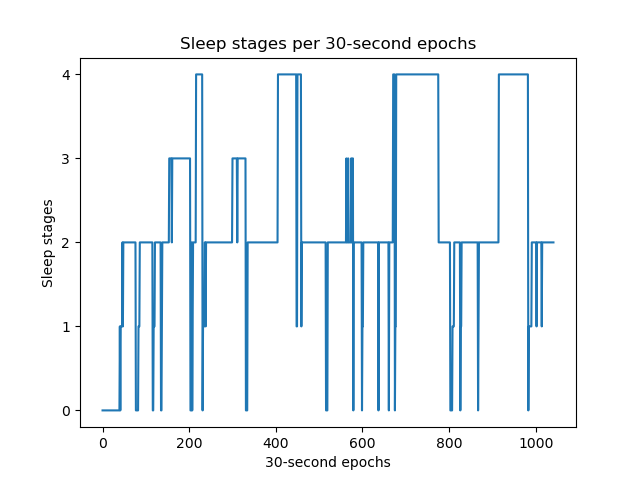

In [88]:
plt.close()
# Visialize sleep stages over time
plt.plot(predictions)
plt.title("Sleep stages per 30-second epochs")
plt.ylabel("Sleep stages")
plt.xlabel("30-second epochs")
plt.yticks(np.unique(predictions))
plt.show()

---

### Get other variables

Variable of how many times a person woke up at night.

In [89]:
# How many minutes are nessecary to see if someone is really awake
min_minutes_awake = 5

# Calculates how many epochs define if someone is awake (*2, because 30-second epochs)
min_epochs_awake = min_minutes_awake * 2

In [90]:
wake_state = 0
wake_up_amount, wake_state_period = 0, 0
# Loop through all predictions
for idx, prediction in enumerate(predictions):
    # Check if person is in wake state
    if prediction == wake_state:
        wake_state_period += 1
    else:
        wake_state_period = 0

    # Check if person is in wake state for exactly 5 minutes
    if wake_state_period == min_epochs_awake:
        wake_up_amount += 1

In [91]:
# Check if wake_state is in begin of sleep
if np.mean(predictions[:min_epochs_awake]) == wake_state:
    wake_up_amount -= 1
# Check if wake_state is in end of sleep
if np.mean(predictions[-min_epochs_awake:]) == wake_state:
    wake_up_amount -= 1

print(f"Person woke up {wake_up_amount} times at the middle of the night.")

Person woke up 0 times at the middle of the night.


Short analysis of the first part of the night

In [92]:
awake_epochs, wake_state_period = 0, 0
# Loop through all predictions
for idx, prediction in enumerate(predictions):
    # Check if person is in wake state
    if prediction == wake_state:
        awake_epochs +=1
    else:
        break


sleep_on_set_latency = int(awake_epochs / 2)
print(f"Person was awake for {sleep_on_set_latency} minutes before falling asleep.")

Person was awake for 20 minutes before falling asleep.


In [93]:
table = [[sleep_on_set_latency, wake_up_amount]]
headers = ["Minutes awake", "Times woken up"]
print(tabulate(table, headers, tablefmt="pretty"))

+---------------+----------------+
| Minutes awake | Times woken up |
+---------------+----------------+
|      20       |       0        |
+---------------+----------------+


In [94]:
def get_results(results_file):
    # Open HDF5 file
    with h5py.File(results_file, 'r') as results:
        # Get confusion matrix
        confusions = results["confusions"][()]
        print(confusions)
    # Get the number of every predicted label
    predicted_label_amount = confusions[0][0]
    predicted_label_amount
    print("0=Wake:\t   ", int(predicted_label_amount[0]))
    print("1=N1/S1:   ", int(predicted_label_amount[1]))
    print("2=N2/S2:   ", int(predicted_label_amount[2]))
    print("3=N3/S3/S4:", int(predicted_label_amount[3]))
    print("4=REM:\t   ", int(predicted_label_amount[4]))
    # Open HDF5 file
    with h5py.File(results_file, 'r') as results:
        predictions = results["predictions"][()][0]
    plt.close()
    # Visialize sleep stages over time
    plt.plot(predictions)
    plt.title("Sleep stages per 30-second epochs")
    plt.ylabel("Sleep stages")
    plt.xlabel("30-second epochs")
    plt.yticks(np.unique(predictions))
    plt.show()
    # How many minutes are nessecary to see if someone is really awake
    min_minutes_awake = 5

    # Calculates how many epochs define if someone is awake (*2, because 30-second epochs)
    min_epochs_awake = min_minutes_awake * 2
    wake_state = 0
    wake_up_amount, wake_state_period = 0, 0
    # Loop through all predictions
    for idx, prediction in enumerate(predictions):
        # Check if person is in wake state
        if prediction == wake_state:
            wake_state_period += 1
        else:
            wake_state_period = 0

        # Check if person is in wake state for exactly 5 minutes
        if wake_state_period == min_epochs_awake:
            wake_up_amount += 1
    # Check if wake_state is in begin of sleep
    if np.mean(predictions[:min_epochs_awake]) == wake_state:
        wake_up_amount -= 1
    # Check if wake_state is in end of sleep
    if np.mean(predictions[-min_epochs_awake:]) == wake_state:
        wake_up_amount -= 1

    print(f"Person woke up {wake_up_amount} times at the middle of the night.")

    # Calculate epochs till person is asleep
    awake_epochs, wake_state_period = 0, 0
    # Loop through all predictions
    for idx, prediction in enumerate(predictions):
        # Check if person is in wake state
        if prediction == wake_state:
            awake_epochs +=1
        else:
            break

    # Calculate sleep-on-set latency
    sleep_on_set_latency = int(awake_epochs / 2)
    print(f"Person was awake for {sleep_on_set_latency} minutes before falling asleep.")

    # Calculate epochs from the moment person is awake
    awake_epochs = 0
    # Loop through all predictions backwards
    for idx, prediction in enumerate(np.flip(predictions)):
        # Check if person is in wake state
        if prediction == wake_state:
            awake_epochs +=1
        else:
            break

    # Calculate wake-up-set latency
    wake_up_set_latency = int(awake_epochs / 2)
    print(f"Person was awake for {wake_up_set_latency} minutes before ending the measurement.")

    # Table with some results
    table = [[sleep_on_set_latency, wake_up_set_latency, wake_up_amount]]
    headers = ["Minutes awake before sleep", "Minutes awake before measurement end", "Times woken up"]
    print(tabulate(table, headers, tablefmt="pretty"))

    # Return all calculations for visualisation in table
    return predicted_label_amount, sleep_on_set_latency, wake_up_set_latency, wake_up_amount

In [148]:
get_results("results_2.h5")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'results_2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

[[[ 66.  42. 499.  45. 190.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]
0=Wake:	    66
1=N1/S1:    42
2=N2/S2:    499
3=N3/S3/S4: 45
4=REM:	    190


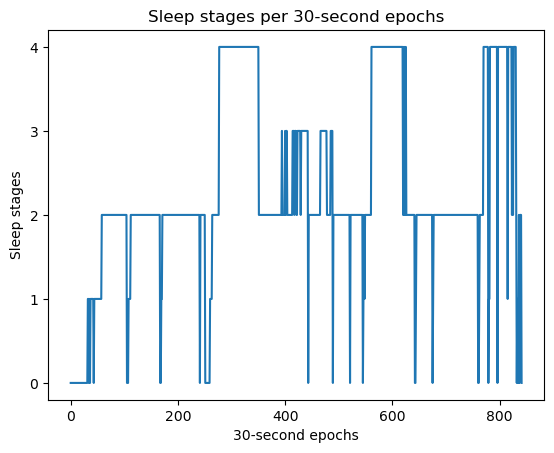

Person woke up 0 times at the middle of the night.
Person was awake for 16 minutes before falling asleep.
Person was awake for 0 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             16             |                  0                   |       0        |
+----------------------------+--------------------------------------+----------------+


(array([ 66.,  42., 499.,  45., 190.], dtype=float32), 16, 0, 0)

In [229]:
get_results("results_3.h5")

[[[123.  43. 606.  41. 203.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]
0=Wake:	    123
1=N1/S1:    43
2=N2/S2:    606
3=N3/S3/S4: 41
4=REM:	    203


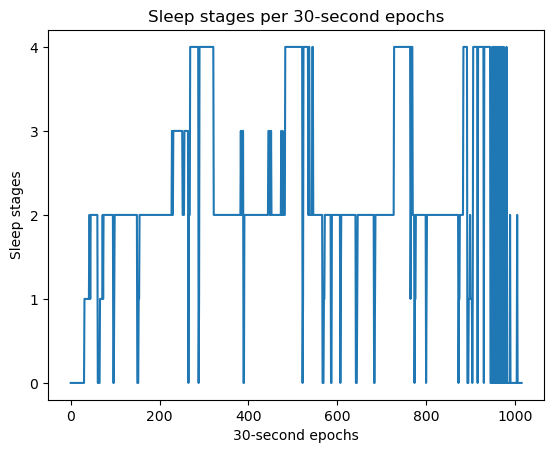

Person woke up 1 times at the middle of the night.
Person was awake for 15 minutes before falling asleep.
Person was awake for 5 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             15             |                  5                   |       1        |
+----------------------------+--------------------------------------+----------------+


(array([123.,  43., 606.,  41., 203.], dtype=float32), 15, 5, 1)

In [ ]:
get_results("results_4.h5")

[[[ 34.  33. 472.  54. 209.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]
0=Wake:	    34
1=N1/S1:    33
2=N2/S2:    472
3=N3/S3/S4: 54
4=REM:	    209


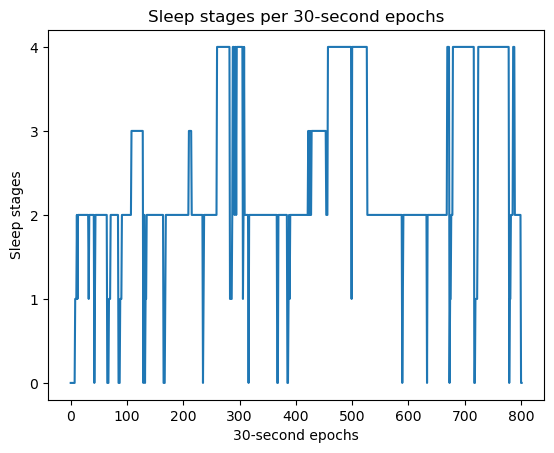

Person woke up 0 times at the middle of the night.
Person was awake for 4 minutes before falling asleep.
Person was awake for 1 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             4              |                  1                   |       0        |
+----------------------------+--------------------------------------+----------------+


(array([ 34.,  33., 472.,  54., 209.], dtype=float32), 4, 1, 0)

In [231]:
get_results("results_5.h5")

[[[ 54.  39. 441. 104. 128.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]
0=Wake:	    54
1=N1/S1:    39
2=N2/S2:    441
3=N3/S3/S4: 104
4=REM:	    128


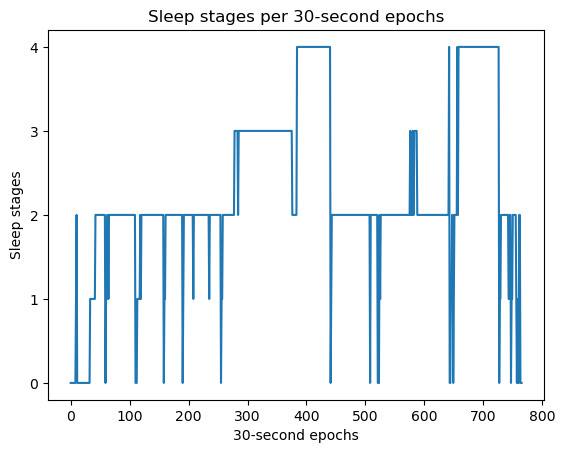

Person woke up 1 times at the middle of the night.
Person was awake for 4 minutes before falling asleep.
Person was awake for 1 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             4              |                  1                   |       1        |
+----------------------------+--------------------------------------+----------------+


(array([ 54.,  39., 441., 104., 128.], dtype=float32), 4, 1, 1)

In [232]:
get_results("results_6.h5")

[[[150.  54. 585.  83. 223.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]
0=Wake:	    150
1=N1/S1:    54
2=N2/S2:    585
3=N3/S3/S4: 83
4=REM:	    223


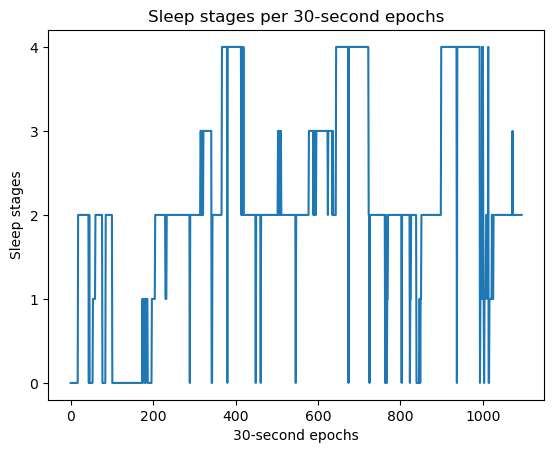

Person woke up 2 times at the middle of the night.
Person was awake for 9 minutes before falling asleep.
Person was awake for 0 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             9              |                  0                   |       2        |
+----------------------------+--------------------------------------+----------------+


In [233]:
predicted_label_amount, sleep_on_set_latency, wake_up_set_latency, wake_up_amount = get_results("results_7.h5")

---

# Sleep quality results

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.interpolate import interp1d
import h5py
from tabulate import tabulate

In [96]:
# Get all information necessary for results table
def get_participant_info(ecg_file_name):
    try:
        # Get the participant number
        participant_number = ecg_file_name.split("/")[-2]
        participant_number = int(participant_number.split("_")[-1])
        print("Measurement of participant {0}".format(participant_number))
    except:
        print("Participant number could not be extracted.")  

    # Get the full file name
    file_name = ecg_file.split("/")[-1]

    try:
        # Get the start date out of the file name
        start_date_time = file_name.split("_")[0]
        start_date_time = start_date_time.split("T")
        start_date = start_date_time[0]

        # Get the start time out of the file name
        start_time = start_date_time[1]
        start_time = start_time.split("Z")[0]

        # Get the start date and time in a nice format
        start_timestamp = datetime.strptime("{0} {1}".format(start_date, start_time), "%Y%m%d %H%M%S")
    except:
        print("Start timestamp could not be extracted.\n")
        print("Are you sure you have the correct file name?")
        print("Expected file name should end like this: xxxxxxxxTxxxxxxZ_xxxxxxxxxxxx_ecg_stream.csv")
        print("Your file name looks like this:", ecg_file)

    # Get df
    df = pd.read_csv(ecg_file)
    # Get timestamps
    first_timestamp = df["timestamp"].iloc[0]
    last_timestamp = df["timestamp"].iloc[-1]
    # Get duration in milliseconds
    duration_milliseconds = last_timestamp - first_timestamp
    print("Measurement took {0} milliseconds.".format(duration_milliseconds))

    # Get the measurement duration in seconds
    duration_seconds = int(duration_milliseconds / 1000)
    # Make a single division to produce both the quotient (minutes) and the remainder (seconds)
    minutes, seconds = divmod(duration_seconds, 60)
    hours, minutes = divmod(minutes, 60)
    print("The measurement duration took {0} seconds.".format(duration_seconds))
    print("That amount equals with {} hours, {} minutes, and {} seconds.".format(hours, minutes, seconds))

    # Add measurement duration to start timestamp
    duration_timestamp = timedelta(seconds=duration_seconds)
    end_timestamp = start_timestamp + duration_timestamp
    print("Measurement started on {0}".format(start_timestamp))
    print("Measurement  ended  on {0}".format(end_timestamp))

    # Return all information for results table
    return participant_number, start_timestamp, end_timestamp

In [97]:
# Get all results necessary for results table
def get_results(results_file):
    # Open HDF5 file
    with h5py.File(results_file, 'r') as results:
        # Get confusion matrix
        confusions = results["confusions"][()]
        print(confusions)
    # Get the number of every predicted label
    predicted_label_amount = confusions[0][0]
    predicted_label_amount
    print("0=Wake:\t   ", int(predicted_label_amount[0]))
    print("1=N1/S1:   ", int(predicted_label_amount[1]))
    print("2=N2/S2:   ", int(predicted_label_amount[2]))
    print("3=N3/S3/S4:", int(predicted_label_amount[3]))
    print("4=REM:\t   ", int(predicted_label_amount[4]))
    # Open HDF5 file
    with h5py.File(results_file, 'r') as results:
        predictions = results["predictions"][()][0]
    plt.close()
    # Visialize sleep stages over time
    plt.plot(predictions)
    plt.title("Sleep stages per 30-second epochs")
    plt.ylabel("Sleep stages")
    plt.xlabel("30-second epochs")
    plt.yticks(np.unique(predictions))
    plt.show()
    # How many minutes are nessecary to see if someone is really awake
    min_minutes_awake = 5

    # Calculates how many epochs define if someone is awake (*2, because 30-second epochs)
    min_epochs_awake = min_minutes_awake * 2
    wake_state = 0
    wake_up_amount, wake_state_period = 0, 0
    # Loop through all predictions
    for idx, prediction in enumerate(predictions):
        # Check if person is in wake state
        if prediction == wake_state:
            wake_state_period += 1
        else:
            wake_state_period = 0

        # Check if person is in wake state for exactly 5 minutes
        if wake_state_period == min_epochs_awake:
            wake_up_amount += 1
    # Check if wake_state is in begin of sleep
    if np.mean(predictions[:min_epochs_awake]) == wake_state:
        wake_up_amount -= 1
    # Check if wake_state is in end of sleep
    if np.mean(predictions[-min_epochs_awake:]) == wake_state:
        wake_up_amount -= 1

    print(f"Person woke up {wake_up_amount} times at the middle of the night.")

    # Calculate epochs till person is asleep
    awake_epochs, wake_state_period = 0, 0
    # Loop through all predictions
    for idx, prediction in enumerate(predictions):
        # Check if person is in wake state
        if prediction == wake_state:
            awake_epochs +=1
        else:
            break

    # Calculate sleep-on-set latency
    sleep_on_set_latency = int(awake_epochs / 2)
    print(f"Person was awake for {sleep_on_set_latency} minutes before falling asleep.")

    # Calculate epochs from the moment person is awake
    awake_epochs = 0
    # Loop through all predictions backwards
    for idx, prediction in enumerate(np.flip(predictions)):
        # Check if person is in wake state
        if prediction == wake_state:
            awake_epochs +=1
        else:
            break

    # Calculate wake-up-set latency
    wake_up_set_latency = int(awake_epochs / 2)
    print(f"Person was awake for {wake_up_set_latency} minutes before ending the measurement.")

    # Table with some results
    table = [[sleep_on_set_latency, wake_up_set_latency, wake_up_amount]]
    headers = ["Minutes awake before sleep", "Minutes awake before measurement end", "Times woken up"]
    print(tabulate(table, headers, tablefmt="pretty"))

    # Return all calculations for visualisation in table
    return predicted_label_amount, sleep_on_set_latency, wake_up_set_latency, wake_up_amount

In [98]:
# Get all results in a table
def get_results_table(ecg_file_name, results_file_name):
    # Get participant info
    participant_number, start_timestamp, end_timestamp = get_participant_info(ecg_file_name)    

    # Get all calculations
    predicted_label_amount, sleep_on_set_latency, wake_up_set_latency, wake_up_amount = get_results(results_file_name)

    print("Deelnemer nummer:", participant_number)

    # Time person fell asleep and woke up
    asleep_timestamp = start_timestamp + timedelta(minutes=sleep_on_set_latency)
    awake_timestamp = end_timestamp - timedelta(minutes=wake_up_set_latency)

    headers = ["Datum van meting", str(start_timestamp.date())]
    table = [["Tijd meting begonnen", start_timestamp.time()],
             ["Tijd in slaap gevallen", asleep_timestamp.time()],
             ["Tijd wakker geworden", awake_timestamp.time()],
             ["Tijd meting beëindigt", end_timestamp.time()], 
             [],
             ["Minuten wakker voordat deelnemer in slaap viel", sleep_on_set_latency],
             ["Minuten wakker voordat deelnemer meting beëindigde", wake_up_set_latency],
             [],
             ["Aantal keer wakker geworden per nacht", wake_up_amount],
             [],
             ["Totaal aantal minuten gemeten", int(sum(predicted_label_amount))/2],
             ["Totaal aantal minuten in wakker fase", int(predicted_label_amount[0])/2],
             ["Totaal aantal minuten in N1 fase", int(predicted_label_amount[1])/2],
             ["Totaal aantal minuten in N2 fase", int(predicted_label_amount[2])/2],
             ["Totaal aantal minuten in N3 fase", int(predicted_label_amount[3])/2],
             ["Totaal aantal minuten in REM fase", int(predicted_label_amount[4])/2],
             [],
             ["Totaal aantal uren gemeten", int((sum(predicted_label_amount))/2)/60],
             ["Totaal aantal uren geslapen", ((int(predicted_label_amount[1])/2)+(int(predicted_label_amount[2])/2)+(int(predicted_label_amount[3])/2)+(int(predicted_label_amount[4])/2))/60]
            ]
    print(tabulate(table, headers, tablefmt="grid"))

    # Write all data to Excel sheet
    excel_results = pd.DataFrame(table)
    excel_filename = "\Results_participant_{0}.xlsx".format(participant_number)

    # Add current directory
    import os
    excel_filename = os.getcwd() + excel_filename

    # Check if excel file exists
    if os.path.exists(excel_filename):
        writer = pd.ExcelWriter(excel_filename, engine='openpyxl', mode="a", if_sheet_exists="replace") # Write an excel data sheet without loosing original data
    else:
        writer = pd.ExcelWriter(excel_filename, engine='openpyxl') # Create excel file with the first data sheet

    excel_results.to_excel(excel_writer=writer, index=False, header=headers, sheet_name=results_file_name.split(".")[0]) # Add excel sheet
    writer.close()
    print(excel_results)

<>:40: SyntaxWarning: invalid escape sequence '\R'
<>:40: SyntaxWarning: invalid escape sequence '\R'
C:\Users\esmee\AppData\Local\Temp\ipykernel_13392\214190074.py:40: SyntaxWarning: invalid escape sequence '\R'
  excel_filename = "\Results_participant_{0}.xlsx".format(participant_number)


In [99]:
ecg_file

'C:/Users/esmee/OneDrive\\Documenten/Hva jaar 4/Afstudeerstage/data/Esmee/MoveSense_data/MoveSense_participant_39/20240803T214653Z_234230000735_ecg_stream.csv'

Measurement of participant 39
Measurement took 31299841 milliseconds.
The measurement duration took 31299 seconds.
That amount equals with 8 hours, 41 minutes, and 39 seconds.
Measurement started on 2024-08-03 21:46:53
Measurement  ended  on 2024-08-04 06:28:32
[[[ 77.  42. 603.  83. 237.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]
0=Wake:	    77
1=N1/S1:    42
2=N2/S2:    603
3=N3/S3/S4: 83
4=REM:	    237


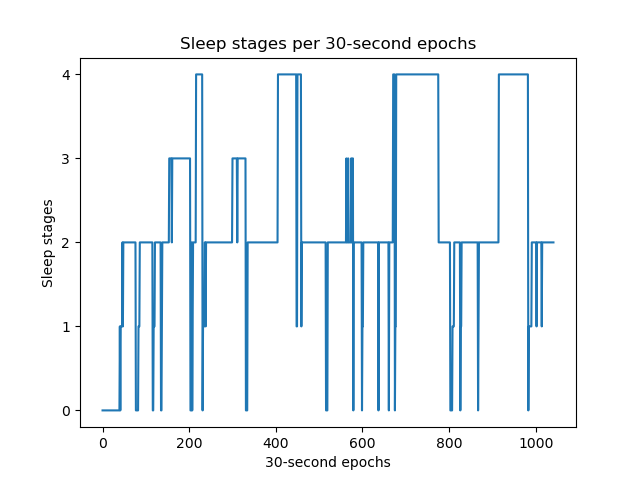

Person woke up 0 times at the middle of the night.
Person was awake for 20 minutes before falling asleep.
Person was awake for 0 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             20             |                  0                   |       0        |
+----------------------------+--------------------------------------+----------------+
Deelnemer nummer: 39
+----------------------------------------------------+-------------------+
| Datum van meting                                   | 2024-08-03        |
+====================================================+===================+
| Tijd meting begonnen                               | 21:46:53          |
+----------------------------------------------------+-------------------+
|

In [100]:
# File names
results_file_name = "results.h5"
ecg_file = "20240803T214653Z_234230000735_ecg_stream"
ecg_file = "C:/Users/esmee/OneDrive/Documenten/Hva jaar 4/Afstudeerstage/data/Esmee/MoveSense_data/MoveSense_participant_39/{0}.csv".format(ecg_file)

# Get all results in a table
get_results_table(ecg_file, results_file_name)

In [154]:
test = "C:/Users/esmee/OneDrive/Documenten/Hva jaar 4/Afstudeerstage/data/Esmee/MoveSense_data/MoveSense_participant_39"
import os
os.path.dirname(os.path.dirname(test))

'C:/Users/esmee/OneDrive/Documenten/Hva jaar 4/Afstudeerstage/data/Esmee'

In [155]:
if not os.path.exists("C:/Users/esmee/OneDrive/Documenten/Hva jaar 4/Afstudeerstage/data/Esmee/MoveSense_data/MoveSense_participant_39/preprocessed_ecg_data_participant_39/"):
    os.makedirs("C:/Users/esmee/OneDrive/Documenten/Hva jaar 4/Afstudeerstage/data/Esmee/MoveSense_data/MoveSense_participant_39/preprocessed_ecg_data_participant_39/")